# 浅谈水文中的Bayesian与MCMC

在水文不确定性分析中，一个十分常见的统计理论就是贝叶斯理论，而实际计算中又常常见到MCMC，这里就来看看这些概念的来龙去脉，好好了解下水文水资源中究竟在用这些东西干什么。本文主要参考了以下资料：

- [用模型不确定性理解模型](https://zhuanlan.zhihu.com/p/43873206)
- [The Value of Regionalised Information for Hydrological Modelling](http://hdl.handle.net/10044/1/28086)
- [MCMC随机采样](https://zhuanlan.zhihu.com/p/30003899)
- [机器学习(一) —— 浅谈贝叶斯和MCMC](https://www.xuyankun.cn/2017/05/13/bayes/)
- [贝叶斯学派与频率学派有何不同？](https://www.zhihu.com/question/20587681)
- [贝叶斯定理，使概率论直觉化](https://www.bilibili.com/video/av84799361)
- [贝叶斯估计、最大似然估计、最大后验概率估计](http://noahsnail.com/2018/05/17/2018-05-17-%E8%B4%9D%E5%8F%B6%E6%96%AF%E4%BC%B0%E8%AE%A1%E3%80%81%E6%9C%80%E5%A4%A7%E4%BC%BC%E7%84%B6%E4%BC%B0%E8%AE%A1%E3%80%81%E6%9C%80%E5%A4%A7%E5%90%8E%E9%AA%8C%E6%A6%82%E7%8E%87%E4%BC%B0%E8%AE%A1/)
- [如何理解似然函数?](https://www.zhihu.com/question/54082000)
- [Treatment of input uncertainty in hydrologic modeling: Doing hydrology backward with Markov chain Monte Carlo simulation](https://doi.org/10.1029/2007WR006720)
- [Equifinality of formal (DREAM) and informal (GLUE) Bayesian approaches in hydrologic modeling?](https://doi.org/10.1007/s00477-008-0274-y)
- [概率笔记11——一维正态分布的最大似然估计](https://www.lagou.com/lgeduarticle/2497.html)
- [机器学习-白板推导系列(十三)-MCMC（Markov Chain Monte Carlo）](https://www.bilibili.com/video/av32430563?p=1)
- [马尔可夫链蒙特卡罗算法（MCMC）](https://zhuanlan.zhihu.com/p/37121528)

## 从问题出发--不确定性

首先来看水文水资源领域我们想用这方法来干什么？

我们平常遇到的很多问题都需要通过建模来解决的，典型地，一个水文模型对应的函数可以简单表示为：$y=f(x,\theta)$，有输入值$x$，有模型$f$，有对应参数$\theta$，就可以求出想要预测或者模拟的y。可是现实世界是复杂的，我们的model只是一种概化地手段，结果存在很大的不确定性，如果我们不能有效的衡量这种不确定性，就拿得到的y去决策，可能会有很大风险，所以从这个角度来说，理解不确定性可以帮助我们尽量避免错误。

既然要考虑不确定性，把结果看作是一个**随机变量**，比如预测径流y，那么如何判断它的概率分布呢？也就是说如何衡量预测结果的不确定性呢？

模型的不确定性有观测的，有模型结构的，有参数本身的，通常我们会假设各个误差源之间没有协变关系，是独立的，然后误差会经过模型计算传递到输出结果上，称之为“forward uncertainty”，现在要计算它，即“forward uncertainty estimation”。所有不确定性都考虑，问题比较复杂，这里先只**考虑模型参数不确定性**的情况，接下来没有特别说明，都是这种情况，也就是f固定，观测当作真值。

通常的方法是这样的，首先是基于特定的模型结构，也就是针对具体的函数f；其次，因为水文水资源很多模型是复杂非线性的，很难显式地去推导它的概率演进，所以我们往往会使用抽样的方法来近似计算。典型的步骤如下图所示：

![](TIM截图20200324232828.png)

也就是随机采样生成参数，然后模拟，最后对得到的结果进行统计分析，做累计经验频率曲线，这样我们可以得到我们结果的置信区间，这就是基本的思路。这种方式是基于蒙特卡洛的方法，所以接下来先看看什么是monte carlo方法。

## Monte Carlo

蒙特卡洛方法也称蒙特卡洛抽样方法，其基本思想是通过**大量取样来近似**得到想要的答案。

一个经典的试验就是计算圆周率，在一个边上为2的正方形中画一个内切圆，圆的面积就是 π，圆面积比上整体的正方形面积也是 π, 现在在正方形内产生大量随机数，最后我们只需要计算在圆内点的个数比上总体点的个数，便近似得到了圆周率 π 的值。

蒙特卡罗原来是一个赌场的名称，用它作为名字大概是因为蒙特卡罗方法是一种随机模拟的方法，这很像赌博场里面的扔骰子的过程。最早的蒙特卡罗方法都是为了求解一些不太好求解的求和或者积分问题。比如积分：
$$\theta=\int_a^b f(x)dx$$
如何模拟呢？假设函数图像如下图:

![](v2-5661858e069a8ca7161b7ba57f872704_720w.jpg)

一个简单的近似求解方法是在[a,b]之间随机的采样一个点。比如 $x_0$ ，然后用 $f(x_0)$ 代表在[a,b]区间上所有的 $f(x)$ 的值。那么上面的定积分的近似求解为:
$$(b-a)f(x_0)$$
当然用一个值代表整个区间，太粗糙了，可以在[a,b]区间上采样n个值，用它们的均值来代表区间上所有的$f(x)$值，这样定积分的近似求解为：
$$\frac{b-a}{n}\sum_{i=0}^{n-1}f(x_i)$$
虽然上面的方法可以一定程度上求解出近似的解，但是它隐含了一个假定，即x在[a,b]之间是均匀分布的，而绝大部分情况，x在[a,b]之间不是均匀分布的。如果我们用上面的方法，则模拟求出的结果很可能和真实值相差甚远。

这时候可以用x在[a,b]的概率分布函数p(x)，那么我们的定积分求和可以这样进行：
$$\theta=\int_a^b f(x)dx=\int_a^b \frac{f(x)}{p(x)}p(x)dx \approx \frac 1 n \sum_{i=0}^{n-1}\frac{f(x_i)}{p(x_i)}$$
上式最右边的这个形式就是**蒙特卡罗方法的一般形式**。当然这里是连续函数形式的蒙特卡罗方法，但是在离散时一样成立。

可以看出，上面我们假设x在[a,b]之间是均匀分布的时候， 就是让上式中的$p(x_i)=1/(b-a)$，也就是说，我们最上面的均匀分布也可以作为一般概率分布函数p(x)在均匀分布时候的特例。那么我们现在的问题转到了如何获取符合分布p(x)的x的若干样本上来。

## 一些基本采样方法

蒙特卡罗方法的关键是得到x的概率分布。如果求出了x的概率分布，我们可以基于概率分布去采样基于这个概率分布的n个x的样本集，带入蒙特卡罗求和的式子即可求解。但是还有一个关键的问题需要解决，即**如何基于概率分布去采样基于这个概率分布的n个x的样本集**。

首先，对于均匀分布uniform(0,1)，是很容易采样的（其方法本身并不简单，想要了解可以自行搜索），已有很多现成的程序可以很方便的生成(0,1)之间的伪随机数。对于其他的概率分布，它们的样本可以通过均匀分布的样本转换得到，比如二维正态分布，可以先采样均匀分布得到$(x_1,x_2)$，然后通过公式转换，公式就不打了，可以参考：https://zhuanlan.zhihu.com/p/30003899 1.3节，逻辑上的理解可以参考这个视频的11分钟左右的内容：https://www.bilibili.com/video/av32430563?p=1

其他一些常见的连续分布，比如t分布，F分布，Beta分布，Gamma分布等，都可以通过类似的方式从uniform(0,1)得到的采样样本转化得到。在python的numpy，scikit-learn等类库中，都有生成这些常用分布样本的函数可以使用。

给个正态分布抽样的简单例子：

(array([ 1.,  4.,  4.,  4.,  6., 10., 14., 27., 29., 39., 44., 63., 62.,
        88., 67., 86., 70., 83., 56., 54., 50., 36., 28., 22., 16., 13.,
         9.,  8.,  4.,  3.]),
 array([72.81542778, 73.5894942 , 74.36356063, 75.13762705, 75.91169347,
        76.68575989, 77.45982632, 78.23389274, 79.00795916, 79.78202558,
        80.55609201, 81.33015843, 82.10422485, 82.87829127, 83.6523577 ,
        84.42642412, 85.20049054, 85.97455696, 86.74862339, 87.52268981,
        88.29675623, 89.07082265, 89.84488908, 90.6189555 , 91.39302192,
        92.16708834, 92.94115477, 93.71522119, 94.48928761, 95.26335403,
        96.03742046]),
 <a list of 30 Patch objects>)

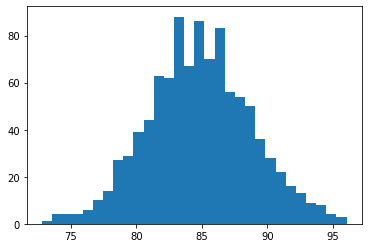

In [1]:
import numpy as np
from numpy.linalg import cholesky
import matplotlib.pyplot as plt

sampleNo = 1000;
mu = 85
sigma = 4
np.random.seed(0)
s = np.random.normal(mu, sigma, sampleNo )
plt.hist(s, 30)

对于概率分布不是常见的分布，一个可行的办法是采用**接受-拒绝采样**来得到该分布的样本。既然 p(z) 太复杂在程序中没法直接采样，那么就设定一个程序可采样的分布 q(z) 比如高斯分布，然后按照一定的方法拒绝某些样本，以达到接近 p(z) 分布的目的，其中q(z)叫做 proposal distribution。

具体采样过程如下，设定一个方便采样的常用概率分布函数 q(z)，以及一个常量 k，使得 p(z) 总在 kq(z) 的下方，如下图所示。

![](v2-e0f2987387b28ab89f8b2065a285a7e4_720w.jpg)

首先，采样得到q(z)的一个样本$z_0$，然后从均匀分布$(0,kq(z_0))$中采样得到要给值u，如果u落在了途中的灰色区域，则拒绝这次抽样，否则就接受这个样本。重复以上过程得到n个接受的样本$z_0,z_1,\cdots,z_{n-1}$，则蒙特卡洛方法求解结果为：
$$\frac 1 n \sum_{i=0}^{n-1}\frac{f(z_i)}{p(z_i)}$$

以上就是一些基本的抽样方法，先到这里。

## 贝叶斯公式

回到径流预报模型函数f上来。我们建模的时候不仅仅是想量化不确定性，还想要不断地利用新的信息来减小不确定性，这就是贝叶斯学派的世界观了。而相对应的，前面提到的抽样获取不确定性的思路就有些频率学派的意思。关于贝叶斯统计的基本思维方式可以参考：https://www.zhihu.com/question/20587681

在贝叶斯视角下，最基本的公式就是贝叶斯公式了。所以我们首先补充下贝叶斯公式相关的基本概念。

贝叶斯公式是本科学过的内容，其基本原理可以参考：https://www.bilibili.com/video/av84799361

这里直接给出公式：
$$\pi(\theta_i|x)=\frac{f(x|\theta_i)\pi(\theta_i)}{\sum_i f(x|\theta_i)\pi(\theta_i)}$$

以上是离散形式下的公式，下面给出连续形式下的：
$$\pi(\theta|x)=\frac{f(x|\theta)\pi(\theta)}{\int_{\Theta} f(x|\theta)\pi(\theta)d\theta}$$

$\pi$是参数的概率分布，$\pi(\theta)$是先验概率，$\pi(\theta|x)$是后验分布，f(x|\theta)是似然函数。积分区间$\Theta$是参数$\theta$所有可能取到的值的域。所以后验概率就是在植到x的前提下，在$\Theta$域内的一个关于$\theta$的概率密度分布，每一个$\theta$都有一个对应的可能性。

现在说下理解，首先似然函数，似然函数是指观测到的样本x的分布是以某个参数$\theta$为前提下得出的。但是参数不知道是多少，所以才会有参数估计，比如本科学的极大似然估计。就是字面意思，把似然算的最大，公式是这样的：
$$lik(\theta)=\prod_{i=1}^nf(x_i|\theta)$$
找到让它最大的$\theta$就是极大似然估计。

关于似然和概率的区别，可以参考：https://www.zhihu.com/question/54082000

接着看看后验概率，后验概率是一系列参数的概率分布，即我们得到了许多个参数及其对应的可能性，我们只需从中选取想要的值即可，比如想要概率最大的那个参数，就是后验众数估计，想要参数分布的中位数，就是后验中位数估计，想要参数分布的均值，就是后验期望估计。这几种没有好坏，只是提供了几种得出参数的方法。

另外，区分下置信区间和可信区间的概念，或者说概率的置信区间和参数的置信区间的概念。置信区间是指参数取一组值时候的概念，比如正态分布某个均值和方差条件下的，95%置信区间表示了一个具体的区间范围。而可信区间是针对后验分布中的参数$\theta$而言的，通过后验分布计算，我们得到了很多参数值，取其中对应概率更大一些的，比如大于95%，这些参数的构成的区间是可信区间。

然后再说说先验分布，最后说是因为先验分布是个对参数概率分布的**主观判断**！如何不知道任何信息，那么取均匀分布即可，即认为所有可能一样，这时候就是无信息先验，因为本文主要目的是了解水文中bayes和MCMC的一些基本应用逻辑，所以下面关于先验的内容，就先考虑无信息先验的情况，这样会简单一些。

上面给出的后验计算公式中，当$\theta$只有一个值时，后验分布分母的那个积分还是可以算的，可以当$\theta$很多时，那是根本没法算的，并且很多时候即便是一个参数，积分可能都是很难算的。所以就有了通过近似来获取答案的方法--即前面提到的蒙特卡洛方法。

现在看回贝叶斯公式，先假设我们已经有了后验概率$\pi (\theta|x)$，如果想要知道关于$\theta$的函数$f(\theta)$的（后验）期望，则根据期望公式有:
$$E[f(\theta)|x]=\int f(\theta)\pi(\theta|x)d\theta$$
当$f(\theta)=\theta$时，就是前面说的后验期望估计，当$f(\theta)$是其他情况时，会得到其他我们想要的结果，比如我们的模型计算。蒙特卡洛方法指出：如果我们可以从**后验概率分布 $\pi (\theta|x)$ 中抽取**大量的独立同分布(i.i.d)的观测值 $\theta_1,\theta_2,\cdots,\theta_m$时 ,于是我们可以用如下公式作为$E[f(\theta)|x]$的近似值（大数定律）
$$f_m=\frac 1 m \sum_{i=1}^m f(\theta _i)$$
所以关键也就是如何抽样了，这就是前面提到的抽样在贝叶斯框架下的作用。

## 问题再看-模型参数率定

在具体到MCMC之前，先进一步思考我们的问题。考虑参数不确定性的情况，一开始的时候我们对参数有一个先验分布的认识，然后在贝叶斯框架下，我们可以根据观测值（似然）来提升我们对模型参数的认识，获取信息更充分的模型参数的概率分布（后验概率）。也就是说，我们有观测值可以帮助我们更好地了解参数，这其实也是水文模型参数率定的知识范围。因为一个典型的参数率定过程如下图所示。

![](TIM截图20200325175743.png)

最上面一行图是上帝视角，不可知的真实的水文响应。通过观测我们可以获取到输入，f是水文模型，经过模型我们可以模拟出响应值，然后和观测的响应值比较，通过比较结果来优化模型的参数，优化前我们对参数有一些了解，比如大致的取值范围等。

因为获取参数的过程是从观测到模型参数，而不是计算的时候从参数到响应，所以通常会将这一过程称为inverse problem（水文中inverse也有不同的涵义，这里就是指求参）。

以上数学表达可以这么写：

公式$y=f(\theta,\widetilde {x})$表示根据观测的forcing data $\widetilde {x}$和模型$f$及其参数$\theta$，可以计算得到模拟的径流值${y}$。

令$\widetilde {y}=\{\widetilde{y_1},\cdots,\widetilde{y_n}\}$表示n个观测值对应的向量。则有残差向量：$E(\theta)=\{y-\widetilde {y}\}=\{{y_1}-\widetilde{y_1},\cdots,{y_n}-\widetilde{y_n}\}=\{e_1(\theta),\cdots,e_n(\theta)\}$

通常我们要找的是令预测和观测差别最小的参数。可以通过最小化simple least squares(SLS)公式$F_{SLS}(\theta)=\sum_{i=1}^n e_i(\theta)^2$来实现。

现在从概率的角度重新看待inverse problem。

首先，考虑关于某个模型f预测的贝叶斯公式：
$$p(\theta|\widetilde {y},\widetilde {x})=\frac{p(\theta)p(\widetilde {y},\widetilde {x}|\theta)}{p(\widetilde {y},\widetilde {x})}$$

为了方便，先把$\widetilde {y},\widetilde {x}$统一到$\widehat{y}$，$\widehat y \in \widehat{\textbf Y}$，$\widehat{\textbf Y}$ 是样本空间。$\theta \in \Theta$，$\Theta$是参数空间。$\widehat{\textbf Y}$和${\Theta}$都有概率分布。$p(\theta)$是参数$\theta$先验分布，描述观测数据之前对参数的了解。$p(\widehat y|\theta)$是给定参数条件下的观测样本分布，我们可以求参数的后验分布。分母$p(\widehat y)$是$\widehat y$和$\theta$的联合分布的边缘分布，所以有：
$$p(\widehat y)=\int _{\Theta} p(\widehat y|\theta)p(\theta)d\theta$$
分母是一个数字，主要是起到一个scaling的作用，保证后验是小于1的，是一个有效的概率分布。所以通常会将贝叶斯公式表示为：
$$p(\theta|\widehat y)=cp(\widehat y|\theta)p(\theta)$$

现在重点是**似然函数**，思考这里的逻辑。和经常拿来做例子的抛硬币不太一样，抛硬币的时候是知道计算n次抛硬币的概率公式的，而这里，参数只能得到模型结果，并没有和观测值之间的关系，也没有概率公式，这就是为什么在模型的不确定性分析里贝叶斯公式比较难理解的原因。

如何理解，这里给出一些个人认识，模型是对现实的概化，模型模拟的结果就是模型使用者对现实的认识，也就是现实的表达，可以将这种表达和现实之间的差别作为似然的表达目标，也就是似然的具体分布由残差的不确定性定义。

另外，我们一般意义下的率定参数本来就是在给定$\widehat y$时求$\theta$，而结合前面似然和概率的概念区别的补充资料，有$p(\widehat y|\theta)=l(\theta|\widehat y)$，也就是说似然和率定在这个时候有相同的含义，只不过是从概率角度分析。

因此我们将残差作为似然的表达对象，为了能让公式有显式的数学表达，一般会假设残差是符合正态分布的，先假设各个时段的残差是独立同分布的正态分布，那么似然函数就是
$$\prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma_e^2}} exp(-\frac{(x_e-\mu _e)^2}{2\sigma_e^2})$$
这部分计算可以参考：https://www.lagou.com/lgeduarticle/2497.html

根据贝叶斯公式，结合先验和似然，就可以显式地写出后验概率分布，也就是参数的后验分布有明确的解析式，那么参数的后验分布就知道了，这时候可以选择概率最大的参数，这就是对参数的最大后验估计，inverse问题就结束了，但是这时候问题就来了，因为往往先验和似然里参数很多，最后得到的后验概率分布会非常复杂，想对这个概率分布做任何分析都不是容易的事，我甚至在各种论文里都没见到过谁把后验分布的完整解析表达式写出来过。

还有，比如根据前一小节的内容，很多时候想要知道的关于$\theta$的函数$f(\theta)$的（后验）期望：$E[f(\theta)|x]=\int f(\theta)\pi(\theta|x)d\theta$，即模型计算结果的后验期望值，这个时候想通过解析计算直接获取，是不可能的，积分计算非常困难，这就是为什么要采用蒙特卡洛模拟的原因，而又因为后验概率分布非常复杂，这就导致前面记录的一些基本的采样方法不能解决问题，这就是**为什么需要MCMC这类方法**的原因了。

## MCMC简介

首先，从统计上来说，参数推断问题是一个很经典的问题，我们有观测数据，这些观测数据有隐变量，就是模型参数，通过观测来推断参数，就是推断过程，也就是前面的求解后验分布的过程。这个过程直接解析表达就是精确推断，而当解析表达的显式计算比较困难时，就有了“近似推断”的方法了，而再近似推断中又有变分推断variation inference这类确定性近似推断方法，还有就是MCMC这类随机性近似推断方法，关于VI的方法可以参考：https://www.bilibili.com/video/BV1aE411o7qd?p=70 ，这里主要记录MCMC。

如前一小节所述，通常讨论MCMC的时候，不会直接拿后验分布来分析，因为太复杂，什么分析都费劲，常常会以关于$\theta$的函数$f(\theta)$的（后验）期望：$E[f(\theta)|x]=\int f(\theta)\pi(\theta|x)d\theta$为分析对象，将积分计算的问题转为蒙特卡洛模拟中的抽样问题，所以现在就来关注抽样问题。

前面已经记录了一些抽样方法，现在进一步记录为什么太复杂的分布就需要MCMC这类方法来抽样才行。

比如概率分布采样，这种方法前面没细说，这里补充下，比如需要对正态分布采样，首先，需要计算出正态分布的CDF，也就是累计概率分布，这样值范围就是[0,1]；然后从[0,1]均匀分布生成一些伪随机数；接下来就可以将刚生成的伪随机数代入CDF的反函数求出对应的值，这样得出的一系列值它们对应的累积分布就是正态分布，所以这些点就是正态分布的采样点了。显然分布复杂时，这里面的CDF计算和反函数计算是困难的。

所以才会又接受拒绝采样这类方法，使用接受-拒绝采样，我们可以解决一些概率分布不是常见的分布的时候，得到其采样集并用蒙特卡罗方法求和的目的。但是接受-拒绝采样也只能部分满足我们的需求，在很多时候我们还是很难得到我们的概率分布的样本集。比如：

- 对于一些二维分布p(x,y)，有时候我们只能得到条件分布，却很难得到二维分布的一般形式，这时候此法很难用；
- 对于一些高维复杂的非常见分布，要找到合适的q(z)和k都非常困难；
- 很依赖于p(z)和q(z)的相似性，越不相似，采样效率越低。

好，现在简单了解了为什么需要MCMC，接下来先看看什么是Markov Chain。

研究生数学课应该有随机过程相关课程，这里面会讲到马尔可夫链，随机过程简言之，就是研究一系列随机变量的规律，马尔科夫链定义本身比较简单，它是个离散的随机过程，时间和状态都是离散的，它假设某一时刻状态转移的概率只依赖于它的前一个状态。数学表达如下：

假设序列状态是 $X_1,X_2,\cdots,X_t,\cdots$，那么在时刻$X_{t+1}$的状态的条件概率仅仅依赖于时刻$X_t$，即:
$$P(X_{t+1}|X_1,X_2,\cdots,X_t)=P(X_{t+1}|X_t)$$

既然某一时刻状态转移的概率只依赖于它的前一个状态，那么我们只要能求出系统中任意两个状态之间的转换概率，这个马尔科夫链的模型就定了。为了方便表达，通常定义矩阵 $P$ 某一位置 $P_{i,j}$ 的值为 $P(j|i)$ ，即从状态 i 转化到状态 j 的概率。接下来，看看状态转移矩阵的一些性质。举个例子，定义牛市为状态0， 熊市为状态1, 横盘为状态2，状态转移矩阵为：
$$P=\begin{bmatrix}
0.9 & 0.075 & 0.025\\ 
0.15 & 0.8 & 0.05\\ 
0.25 & 0.25 & 0.5
\end{bmatrix}$$

假设当前股市的概率分布是[0.3,0.4,0.3]，然后这个状态作为序列概率分布的初始状态，并将其带入状态转移矩阵计算：

In [2]:
import numpy as np
matrix = np.matrix([[0.9,0.075,0.025],[0.15,0.8,0.05],[0.25,0.25,0.5]])
vector = np.matrix([[0.3,0.4,0.3]])
for i in range(80):
    vector = vector * matrix
    print("current round",i+1)
    print(vector)

current round 1
[[0.405  0.4175 0.1775]]
current round 2
[[0.4715  0.40875 0.11975]]
current round 3
[[0.5156 0.3923 0.0921]]
current round 4
[[0.54591  0.375535 0.078555]]
current round 5
[[0.567288 0.36101  0.071702]]
current round 6
[[0.5826362 0.3492801 0.0680837]]
current round 7
[[0.59378552 0.34014272 0.06607176]]
current round 8
[[0.60194632 0.33316603 0.06488765]]
current round 9
[[0.6079485  0.32790071 0.06415079]]
current round 10
[[0.61237646 0.3239544  0.06366914]]
current round 11
[[0.61564926 0.32100904 0.0633417 ]]
current round 12
[[0.61807111 0.31881635 0.06311253]]
current round 13
[[0.61986459 0.31718655 0.06294886]]
current round 14
[[0.62119333 0.3159763  0.06283037]]
current round 15
[[0.62217803 0.31507813 0.06274383]]
current round 16
[[0.62290791 0.31441182 0.06268027]]
current round 17
[[0.62344896 0.31391762 0.06263343]]
current round 18
[[0.62385006 0.31355112 0.06259882]]
current round 19
[[0.62414743 0.31327936 0.06257322]]
current round 20
[[0.62436789 0

可以看到，从第60轮开始，状态概率分布就不变了，一直保持在[0.625 0.3125 0.0625]，可以换个初始概率再看看。

In [3]:
vector1 = np.matrix([[0.7,0.1,0.2]])
for i in range(80):
    vector1 = vector1 * matrix
    print("current round",i+1)
    print(vector1)

current round 1
[[0.695  0.1825 0.1225]]
current round 2
[[0.6835  0.22875 0.08775]]
current round 3
[[0.6714 0.2562 0.0724]]
current round 4
[[0.66079  0.273415 0.065795]]
current round 5
[[0.652172 0.28474  0.063088]]
current round 6
[[0.6454378 0.2924769 0.0620853]]
current round 7
[[0.64028688 0.29791068 0.06180244]]
current round 8
[[0.6363954  0.30180067 0.06180393]]
current round 9
[[0.63347695 0.30462117 0.06190188]]
current round 10
[[0.6312979  0.30668318 0.06201892]]
current round 11
[[0.62967532 0.30819862 0.06212607]]
current round 12
[[0.62846909 0.30931606 0.06221485]]
current round 13
[[0.6275733  0.31014174 0.06228495]]
current round 14
[[0.62690847 0.31075263 0.0623389 ]]
current round 15
[[0.62641525 0.31120496 0.06237979]]
current round 16
[[0.62604941 0.31154006 0.06241053]]
current round 17
[[0.62577811 0.31178839 0.0624335 ]]
current round 18
[[0.62557693 0.31197244 0.06245062]]
current round 19
[[0.62542776 0.31210888 0.06246336]]
current round 20
[[0.62531716 0

可以看到，尽管采用了不同初始概率分布，最终状态的概率分布还是会趋于同一个稳定的概率分布[0.625 0.3125 0.0625]， 即马尔科夫链模型的状态转移矩阵收敛到的稳定概率分布与初始状态概率分布无关。这是一个非常好的性质，也就是说，如果我们得到了这个稳定概率分布对应的马尔科夫链模型的状态转移矩阵，则我们可以用任意的概率分布样本开始，带入马尔科夫链模型的状态转移矩阵，这样经过一些序列的转换，最终就可以得到符合对应稳定概率分布的样本。

这个性质不光对我们上面的状态转移矩阵有效，对于绝大多数的其他的马尔科夫链模型的状态转移矩阵也有效。同时不光是离散状态，连续状态时也成立。

同时，对于一个确定的状态转移矩阵 $P$ ，它的 n 次幂 $P^n$ 在当n大于一定的值的时候也可以发现是确定的，还是上例：

In [4]:
import numpy as np
matrix = np.matrix([[0.9,0.075,0.025],[0.15,0.8,0.05],[0.25,0.25,0.5]])
for i in range(10):
    matrix = matrix * matrix
    print("current round",i+1)
    print(matrix)

current round 1
[[0.8275  0.13375 0.03875]
 [0.2675  0.66375 0.06875]
 [0.3875  0.34375 0.26875]]
current round 2
[[0.73555  0.212775 0.051675]
 [0.42555  0.499975 0.074475]
 [0.51675  0.372375 0.110875]]
current round 3
[[0.65828326 0.28213131 0.05958543]
 [0.56426262 0.36825403 0.06748335]
 [0.5958543  0.33741675 0.06672895]]
current round 4
[[0.62803724 0.30972343 0.06223933]
 [0.61944687 0.3175772  0.06297594]
 [0.6223933  0.3148797  0.062727  ]]
current round 5
[[0.62502532 0.31247685 0.06249783]
 [0.6249537  0.31254233 0.06250397]
 [0.62497828 0.31251986 0.06250186]]
current round 6
[[0.625  0.3125 0.0625]
 [0.625  0.3125 0.0625]
 [0.625  0.3125 0.0625]]
current round 7
[[0.625  0.3125 0.0625]
 [0.625  0.3125 0.0625]
 [0.625  0.3125 0.0625]]
current round 8
[[0.625  0.3125 0.0625]
 [0.625  0.3125 0.0625]
 [0.625  0.3125 0.0625]]
current round 9
[[0.625  0.3125 0.0625]
 [0.625  0.3125 0.0625]
 [0.625  0.3125 0.0625]]
current round 10
[[0.625  0.3125 0.0625]
 [0.625  0.3125 0.0625]

可以看到，在n≥6以后，$P^n$ 的值稳定不再变化，而且每一行都为[0.625 0.3125 0.0625]，这和我们前面的稳定分布是一致的。这个性质同样不光是离散状态，连续状态时也成立。

这其实就是马氏链的平稳分布，马氏链平稳分布的一些性质列举如下：

如果一个非周期的马尔可夫链有状态转移矩阵P，并且它的任何两个状态是连通的，那么$\lim_{n\to\infty} P_{ij}^n$ 与初始状态无关，有：

- $\lim_{n\to\infty} P_{ij}^n = \pi(j)$
- $\lim_{n\to\infty} P^n = \begin{bmatrix}
\pi(1) & \pi(2) & \cdots & \pi(j) & \cdots\\ 
\pi(1) & \pi(2) & \cdots & \pi(j) & \cdots\\ 
\vdots & \vdots & \vdots & \ddots & \vdots\\ 
\pi(1) & \pi(2) & \cdots & \pi(j) & \cdots\\ 
\vdots & \vdots & \vdots & \ddots & \vdots
\end{bmatrix}$
- $\pi(j)=\sum_{i=0}^\infty \pi(i)P_{ij}$
- $\pi$是方程$\pi P=\pi$的唯一非负解，其中，$\pi=[\pi(1),\pi(2),\cdots,\pi(j),\cdots]$，$\sum_{i=1}^\infty\pi(i)=1$，$\pi$称为马氏链的平稳分布

简单解释下

- 非周期的马尔科夫链是指马尔科夫链的状态转化不是循环的，如果是循环的则永远不会收敛。幸运的是遇到的马尔科夫链一般都是非周期性的。用数学方式表述则是：对于任意某一状态 i , d 为集合 $\{n|n>=1,P_{ii}^n>0\}$ 的最大公约数，如果 d=1 ，则该状态为非周期的
- 任何两个状态是连通的指的是从任意一个状态可以通过有限步到达其他的任意一个状态，不会出现条件概率一直为0导致不可达的情况，即 $P^n$ 中任意一个元素都大于零。
- 马尔科夫链的状态数可以是有限的，也可以是无限的。因此可以用于连续概率分布和离散概率分布。
- 用$X_i$表示在马氏链上跳转第i步后所处的状态，如果$\lim_{n\to \infty}P_{ij}^n=\pi(j)$存在，很容易很容易证明以上定理的第三个结论。由于$P(X_{n+1}=j)=\sum_{i=0}^\infty P(X_n=i)P(X_{n+1}=j|X_n=i)=\sum_{i=0}^{\infty}P(X_n=i)P_{ij}$，两边取极限就可以得到$\pi(j)=\sum_{i=0}^\infty\pi(i)P_{ij}$
- 由马氏链收敛的定理, 概率分布 $\pi_i(x)$ 将收敛到平稳分布 $\pi(x)$ 。假设到第 n 步的时候马氏链收敛，则有 $X_n \sim \pi(x),X_{n+1}\sim\pi(x),X_{n+2}\sim\pi(x),\cdots$ ，所以 $X_n,X_{n+1},X_{n+2},\cdots,\pi(x)$ 都是同分布的随机变量，当然他们并不独立。如果我们从一个具体的初始状态 $x_{0}$开始, 沿着马氏链按照概率转移矩阵做跳转，那么我们得到一个转移序列 $x_0,x_1,x_2,\cdots,x_{n-1},x_{n},x_{n+1},\cdots$ ，由于马氏链的收敛行为， $x_n,x_{n+1},\cdots$ 都将是平稳分布 $\pi(x)$ 的样本。

那么，为什么MCMC要引入平稳分布呢？因为如果构造一个平稳分布$\pi(k)$ 就是前面一直说的后验p(z)，那么就可以通过如下方式采样：

1. 首先，基于初始任意简单概率分布比如高斯分布 $\pi_0(x)$ 采样得到状态值 $x_0$ 
2. 基于条件概率分布 $P(x|x_0)$ 采样状态值 $x_1$
3. 一直进行下去，当状态转移进行到一定的次数时，比如到 n 次时，我们认为此时的采样集 $(x_n,x_{n+1},\cdots)$ 即是符合我们的平稳分布的对应样本集，可以用来做蒙特卡罗模拟了。

所以现在问题就转化为如何引入平稳分布，即如果把后验分布p(z)看作是平稳分布$\pi (k)$的话，是不是可以通过构造马氏链让其逼近p(z)呢？

所以现在要了解马氏链能收敛到平稳分布的充分条件是什么呢？即什么时候一个分布{$\pi(k)$}是{$x_k$}的平稳分布，也就是通过什么条件能构造一个平稳分布？

这就是细致平稳条件 detailed balance condition:如果非周期马尔可夫状态转移矩阵P和概率分布$\pi(x)$对所有$i,j$，满足 $\pi (i)p(i \to j)=\pi(j)p(j\to i)$ （$p(i \to j)$表示转移概率，实际上就是已知i的时候，j的条件概率），则概率分布$\pi(x)$就是状态矩阵P的平稳分布。

理解也不难，就是$\sum_i\pi (i)P(i\to j)=\sum_i\pi(j)P(j\to i)=\pi(j)\sum_i P(j\to i) = \pi(j)$，所以$\pi P=\pi$，就是平稳分布了。

根据前面的充分条件，可以通过下面的方式，构造平稳分布：

首先，随机定义一个状态转移矩阵$Q=[Q_{ij}]$，令
$$p(z)Q(z\to z^*)\alpha(z,z*)=p(z^*)Q(z^*\to z)\alpha(z*,z)$$其中，
$$\alpha(z,z^*)=min(1,\frac{p(z^*)Q(z^*\to z)}{p(z)Q(z\to z^*)})$$

然后就可以得到分布$\pi(x)$是状态转移矩阵$P_{ij}=Q_{ij}\alpha_{ij}$的平稳分布了。

其中 $\alpha_{ij}$ 一般称之为接受率，取值在 [0,1] 之间，可以理解为一个概率值。这很像接受-拒绝采样，那里是以一个常用分布通过一定的接受-拒绝概率得到一个非常见分布， 这里是以一个常见的马尔科夫链状态转移矩阵 Q 通过一定的接受-拒绝概率得到目标转移矩阵 P ,两者的解决问题思路是类似的。图示如下。

![](v2-48086a0f62774d98f6b672b91d2dcda0_720w.jpg)

这就是最经典的MCMC算法，Metropolis-Hastings算法，简称MH算法。具体步骤如下：

1. 输入任意给定的马尔科夫链状态转移矩阵 Q ，目标平稳分布 $\pi(x)$ ，设定状态转移次数阈值 $n_1$ ，需要的样本数 $n_2$ ;
2. 从任意简单概率分布得到初始状态值 $x_0$ ；
3. for t=0 in $ n_1+n_2+1 $
    - a. 从条件概率分布 $Q(x|x_t)$ 得到样本值 $x^*$
    - b. 从均匀分布中采样
    - c. 如果 $u<\alpha(x_t,x^*)=\pi(x^*)Q(x^*,x_t)$ ，则接受 $x_t \to x^*$ ，即 $x_{t+1}=x^*$
    - d. 否则不接受转移， t=max{t-1,0}

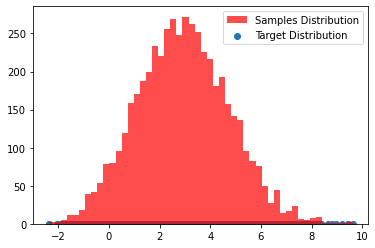

In [5]:
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm

def norm_dist_prob(theta):
    y = norm.pdf(theta, loc=3, scale=2)
    return y

T = 5000
pi = [0 for i in range(T)]
sigma = 1
t = 0
while t < T-1:
    t = t + 1
    pi_star = norm.rvs(loc=pi[t - 1], scale=sigma, size=1, random_state=None)   #状态转移进行随机抽样
    alpha = min(1, (norm_dist_prob(pi_star[0]) / norm_dist_prob(pi[t - 1])))   #alpha值

    u = random.uniform(0, 1)
    if u < alpha:
        pi[t] = pi_star[0]
    else:
        pi[t] = pi[t - 1]


plt.scatter(pi, norm.pdf(pi, loc=3, scale=2),label='Target Distribution')
num_bins = 50
plt.hist(pi, num_bins, facecolor='red', alpha=0.7,label='Samples Distribution')
plt.legend()
plt.show()

按照前面第一次分析问题时就说明的情况，通常为了简化问题，经常只考虑参数不确定性，而实际中至少观测的模型输入值也是有不确定性的，这时候是可以通过贝叶斯框架来量化这类不确定性，给出概率分布，这也是贝叶斯框架的另一个优势--不只是一种新视角，还能考虑多种不确定性，这方面可以参考文献：https://doi.org/10.1029/2007WR006720